In [43]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os.path
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.platform import gfile
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
%matplotlib inline

In [2]:
image_dir = 'Images'
image_size = 64

In [3]:
sub_dirs = [
    os.path.join(image_dir,item)
    for item in gfile.ListDirectory(image_dir)]
sub_dirs

['Images\\Beds', 'Images\\Chairs', 'Images\\Tables', 'Images\\Wardrobe']

In [4]:
training_images=[]

# building training dataset
for item in gfile.ListDirectory(image_dir):
    for pic in gfile.ListDirectory(image_dir+'/'+item):
        img=cv2.imread(image_dir+'/'+item+'/'+pic)
        resize = cv2.resize(img,(image_size,image_size))
        training_images.append((resize,item))

In [33]:
len(training_images)

207

In [25]:
np.shape(training_images[0])

(64, 64, 3)

In [6]:
X=[]
Y=[]
#shuffling the images
random.shuffle(training_images)

#building X and Y
for i in range(len(training_images)):
    X.append(training_images[i-1][0])
    Y.append(training_images[i-1][1])

Tables


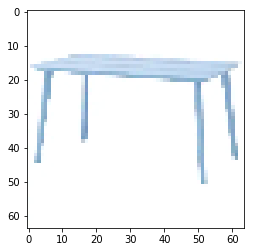

In [7]:
print(Y[100])
plt.imshow(X[100])

In [8]:
#Normalizing the data
X = np.array(X,dtype=float)
X = X/255.0


train_Y=[]
for x in Y:
    if x=='Beds':
        train_Y.append(0)
    elif x=='Wardrobe':
        train_Y.append(1)
    elif x=='Chairs':
        train_Y.append(2)
    else:
        train_Y.append(3)
        
Y= np.array(train_Y)

In [16]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(image_size,image_size,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(4))
model.add(Activation('softmax'))
# compile model
#opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
activation_12 (Activation)   (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
activation_13 (Activation)   (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
__________

In [17]:
history = model.fit(X, Y, epochs=100, batch_size=32, verbose=0, validation_split=0.1)

In [18]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


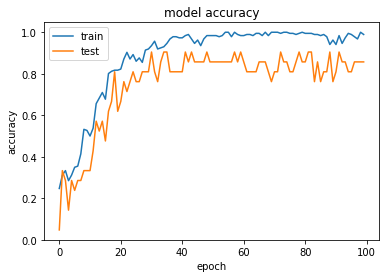

In [19]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

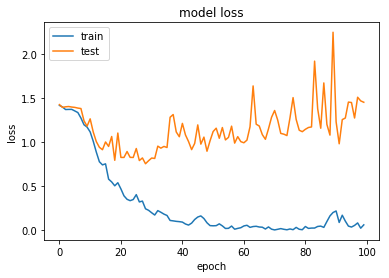

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
history.history['val_acc'][-1]

0.8571428656578064

In [27]:
model.save('ikeaClassify.h5')

In [30]:
#Pick the first Fully-Connected layer as the features for Random Forest Model
layer_name = 'dense_4'
FC_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

In [35]:
FC_layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
activation_12 (Activation)   (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
activation_13 (Activation)   (None, 29, 29, 64)        0         
__________

In [36]:
training_features= []
training_features= FC_layer_model.predict(X)

In [38]:
len(training_features)

207

In [39]:
len(training_features[0])

128

In [40]:
np.save('features', training_features)

In [41]:
#Name the feature rows as f_0, f_1, f_2...
feature_col=[]
for i in range(128):
    feature_col.append("f_"+str(i))

In [44]:
#Create DataFrame with features and coloumn name
train_features=pd.DataFrame(data=training_features,columns=feature_col)
feature_col = np.array(feature_col)

print('Training Features Shape:', train_features.shape)

Training Features Shape: (207, 128)


In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, Y, test_size=0.20)

In [48]:
#Feed the extracted features with the labels to RANDOM FOREST 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 50, random_state = 42)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [49]:
rf_pred = rf.predict(X_test)

In [51]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,rf_pred))

[[ 5  0  0  0]
 [ 0 12  0  0]
 [ 1  0 12  0]
 [ 0  0  0 12]]


In [53]:
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00        12
           2       1.00      0.92      0.96        13
           3       1.00      1.00      1.00        12

    accuracy                           0.98        42
   macro avg       0.96      0.98      0.97        42
weighted avg       0.98      0.98      0.98        42

